In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
biogrid = '../out/biogrid.all.txt'
biogrid_genetic = '../out/biogrid.genetic.txt'
obo = '../out/SGD_slim.obo'
gaf = '../out/SGD_slim.tsv'
threshold = 0.5

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy

In [4]:
def cohens(x, y):
    r"""Effect size metric through Cohen's *d* metric
    :param x: first vector
    :param y: second vector
    :return: absolute effect size value
    The Cohen's effect size *d* is defined as the difference
    between two means divided by a standard deviation of the data.
    .. math::
        d = \frac{\bar{x}_1 - \bar{x}_2}{s}
    For two independent samples, the *pooled standard deviation* is used
    instead, which is defined as:
    .. math::
        s = \sqrt{  \frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2} }
    A Cohen's *d* is frequently used in estimating sample sizes for
    statistical testing: a lower *d* value indicates the necessity of
    larger sample sizes, and vice versa.
    .. note:: we return the absolute value
    :references: https://en.wikipedia.org/wiki/Effect_size
    """
    x = np.array(x)
    y = np.array(y)

    Nx = len(x) - 1.  # note the dot to cast to float
    Ny = len(y) - 1.
    # mean difference:
    md = np.abs(x.mean() - y.mean())
    # here, we want same as in R that is unbiased variance
    # so we use ddof = 1
    xv = x.var(ddof=1)
    yv = y.var(ddof=1)
    csd = Nx * xv + Ny * yv
    csd /= Nx + Ny  # make sure this is float
    csd = np.sqrt(csd)

    return md / csd

In [5]:
def compare(w, df,
            iterations=10,
            name='',
            threshold=0.1):
    idx = df.index.intersection(w.index)

    y = w.loc[idx]
    df = df.loc[idx]

    res = []
    for x in df.loc[y[y > threshold].index].values:
        res.append((name, 'real', x))
    for i in range(iterations):
        for x in df.loc[y[y <= threshold].sample(n=y[y > threshold].shape[0]).index]:
            res.append((name, 'random%d' % i, x))
    for x in df.loc[y[y <= threshold].index]:
        res.append((name, 'random', x))
    r = pd.DataFrame(res,
                     columns=['name', 'set', 'v'])

    return r

In [6]:
def go_enrich(pop, study,
              go, obodag):
    res = []
    goeaobj = GOEnrichmentStudy(pop,
                                go, obodag,
                                propagate_counts=False,
                                alpha=0.05,
                                methods=['fdr_bh'],
                                log=None)
    goe = goeaobj.run_study(study,
                            log=None)
    for xx in goe:
        res.append([xx.goterm.id,
                    xx.goterm.namespace,
                    xx.goterm.depth,
                    xx.goterm.name,
                    '%d/%d' % xx.ratio_in_study,
                    '%d/%d' % xx.ratio_in_pop,
                    xx.p_uncorrected,
                    xx.p_fdr_bh])
    g = pd.DataFrame(res,
                     columns=['go',
                              'go_namespace',
                              'go_depth',
                              'go_name',
                              'ratio_in_study',
                              'ratio_in_population',
                              'pvalue',
                              'qvalue'])
    g = g[g['qvalue'] < 0.01]
    return g

In [7]:
obodag = GODag(obo)
go = {}
rgo = {}
for l in open(gaf):
    gene, gos = l.rstrip().split()
    go[gene] = set(gos.split(';')) - {''}
    for gterm in set(gos.split(';')) - {''}:
        rgo[gterm] = rgo.get(gterm, set())
        rgo[gterm].add(gene)

../out/SGD_slim.obo: fmt(1.2) rel(None) 254 GO Terms


In [8]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [9]:
it = {}
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    it[g1] = it.get(g1, 0)
    it[g2] = it.get(g2, 0)
    it[g1] += 1
    it[g2] += 1

In [10]:
gi = pd.read_table(biogrid_genetic)
git = {}
for g1, g2 in gi[(gi['interaction'] == 'negative') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    git[g1] = git.get(g1, 0)
    git[g2] = git.get(g2, 0)
    git[g1] += 1
    git[g2] += 1
pit = {}
for g1, g2 in gi[(gi['interaction'] == 'positive') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    pit[g1] = pit.get(g1, 0)
    pit[g2] = pit.get(g2, 0)
    pit[g1] += 1
    pit[g2] += 1

In [11]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
pgenes = set(pgenes[pgenes == True].index)

UWOP 4014
YPS 4093
Y55 4190
S288C 4889

total 3786


In [12]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

In [13]:
strains = {y
           for x in d.index
           for y in x[:2]}

In [14]:
w = d[d['qvalue'] < 0.01].groupby('gene').count()['qvalue'].sort_values() / 6.

In [15]:
go_enrich(set(w[w > 0.5].index),
          set(genes),
          obodag=obodag, go=go)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


,go,go_namespace,go_depth,go_name,ratio_in_study,ratio_in_population,pvalue,qvalue


In [16]:
it = pd.Series(it)
git = pd.Series(git)
pit = pd.Series(pit)

# it = it / it.max()
# git = git / git.max()
# pit = pit / pit.max()

In [17]:
res = []
for df, name in zip([it,
                     git, pit],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive']):
    res.append(compare(w, df, name=name,
                       threshold=0.5))
r = pd.concat(res)

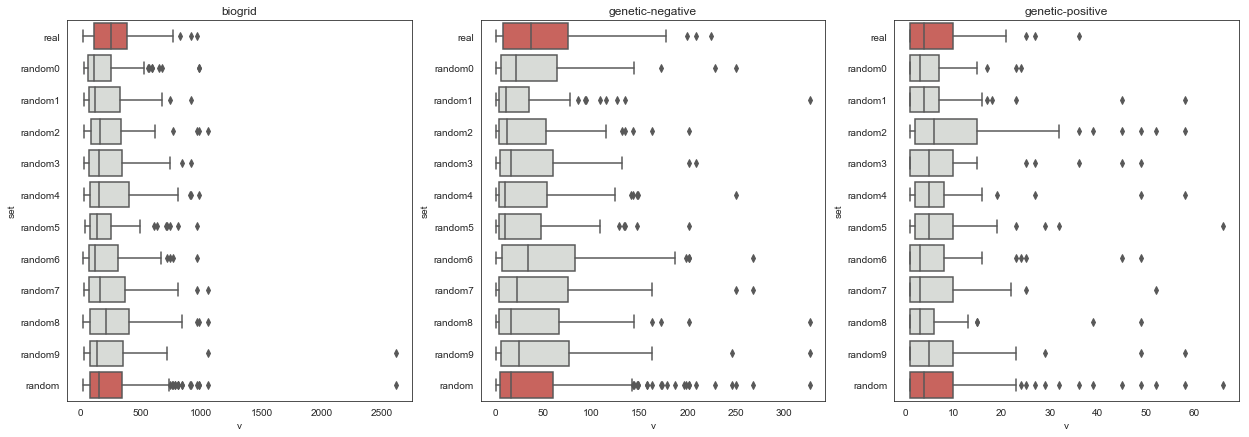

In [18]:
plt.figure(figsize=(21, 7))

for i, name in enumerate(r['name'].unique()):
    plt.subplot(1, 3, i+1)
    
    sns.boxplot(data=r[r['name'] == name],
                x='v',
                y='set',
                palette=[sns.xkcd_rgb['pale red']] +
                        [sns.xkcd_rgb['light grey']] * 10)
    
    plt.title(name);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


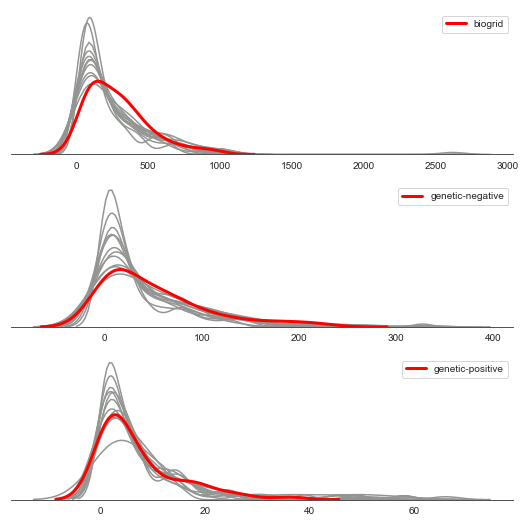

In [19]:
plt.figure(figsize=(9, 9))

for i, name in enumerate(r['name'].unique()):
    plt.subplot(3, 1, i+1)
    
    sns.kdeplot(r[(r['name'] == name) &
                  (r['set'] == 'real')]['v'],
                color='r',
                label=name,
                lw=3)
    for x in r[(r['name'] == name) &
               (r['set'] != 'real')]['set'].unique():
        sns.kdeplot(r[(r['name'] == name) &
                      (r['set'] == x)]['v'],
                    color=sns.xkcd_rgb['grey'],
                    label='_',
                    zorder=0)
    
#     plt.xlim(-0.05, 1.05)
    plt.yticks([])
    
sns.despine(left=True)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


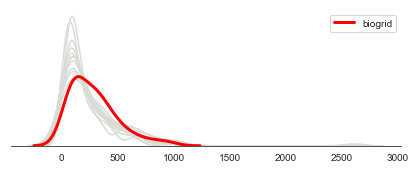

In [20]:
plt.figure(figsize=(7, 2.5))

name = 'biogrid'

sns.kdeplot(r[(r['name'] == name) &
              (r['set'] == 'real')]['v'],
            color='r',
            label=name,
            lw=3)
for x in r[(r['name'] == name) &
           (r['set'] != 'real')]['set'].unique():
    sns.kdeplot(r[(r['name'] == name) &
                  (r['set'] == x)]['v'],
                color=sns.xkcd_rgb['light grey'],
                label='_',
                alpha=1,
                zorder=0)

# plt.xlim(-0.05, 0.405)
plt.yticks([])
    
sns.despine(left=True)

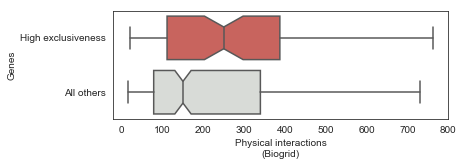

In [21]:
plt.figure(figsize=(6, 2))

name = 'biogrid'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False)
    
plt.ylabel('Genes')
plt.xlabel('Physical interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others'])

plt.savefig('biogrid.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [22]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.21507560370119613, pvalue=0.002489035976332139)

In [23]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.2060686456656139

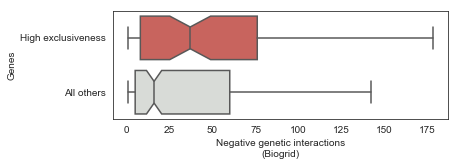

In [24]:
plt.figure(figsize=(6, 2))

name = 'genetic-negative'
sns.boxplot(data=r[(r['name'] == name) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False)
    
plt.ylabel('Genes')
plt.xlabel('Negative genetic interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['High exclusiveness',
            'All others'])

plt.savefig('biogrid-genetic.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid-genetic.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [25]:
stats.ks_2samp(r[(r['name'] == name) &
                   (r['set'] == 'real')]['v'],
               r[(r['name'] == name) &
                   (r['set'] == 'random')]['v'])

Ks_2sampResult(statistic=0.16624652575786963, pvalue=0.04404661067935672)

In [26]:
cohens(r[(r['name'] == name) &
         (r['set'] == 'real')]['v'],
       r[(r['name'] == name) &
         (r['set'] == 'random')]['v'])

0.20064532595911602

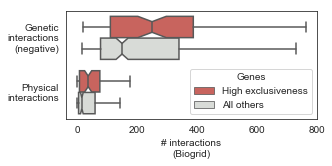

In [27]:
plt.figure(figsize=(4.5, 2))

names = ['genetic-negative',
         'biogrid']
sns.boxplot(data=r[(r['name'].isin(names)) &
                   (r['set'].isin(['real',
                                   'random']))],
            x='v',
            y='name',
            hue='set',
            palette=[sns.xkcd_rgb['pale red']] +
                    [sns.xkcd_rgb['light grey']],
            notch=True,
            showfliers=False)
    
plt.ylabel('')
plt.xlabel('# interactions\n(Biogrid)')
plt.yticks([0, 1],
           ['Genetic\ninteractions\n(negative)',
            'Physical\ninteractions'])

l = plt.legend(title='Genes')
l.get_texts()[0].set_text('High exclusiveness')
l.get_texts()[1].set_text('All others')

plt.savefig('biogrid-both.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('biogrid-both.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

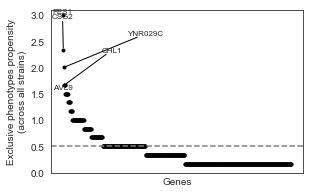

In [28]:
plt.figure(figsize=(4.5, 3))

x = d[d['qvalue'] < 0.01].groupby('gene').count()['qvalue'].sort_values() / 6.
idx = x.sort_values(ascending=False).index

obj = plt.plot(range(x.shape[0]),
               x.sort_values(ascending=False),
               'k.')

texts = [plt.text(i, y, gn.get(k, k),
                  ha='center',
                  va='center',
                  size=8)
         for i, (k, y) in enumerate(x.sort_values(ascending=False).head(5).iteritems())]
iterations = adjust_text(texts,
                         arrowprops=dict(arrowstyle='-',
                                         color='k'),
                         force_text=0.5,
                         add_objects=obj)

plt.gca().invert_yaxis()

plt.axhline(0.5,
            color='grey',
            ls='dashed')

plt.xlabel('Genes')
plt.xticks([])
plt.ylim(-0.01, 3.1)
plt.ylabel('Exclusive phenotypes propensity\n(across all strains)')

plt.savefig('exclusiveness_all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('exclusiveness_all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [29]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

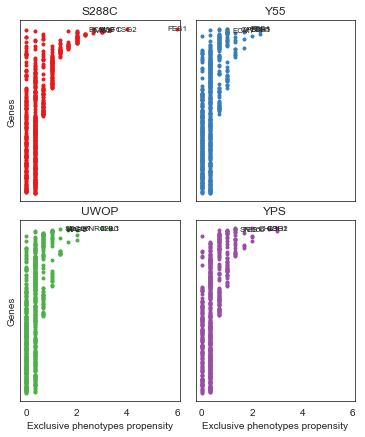

In [30]:
plt.figure(figsize=(6, 7))

for i, strain in enumerate(strains):
    plt.subplot(2, 2, i+1)
    
    dd = d.reset_index()
    x = dd[(dd['qvalue'] < 0.01) &
           ((dd['strain1'] == strain) |
            (dd['strain2'] == strain))].groupby('gene').count()['qvalue'].sort_values() / 3.
    x = x.reindex(idx, fill_value=0)

    obj = plt.plot(x,
                   range(x.shape[0]),
                   '.',
                   color=cstrains[strain])

    texts = [plt.text(y, i, gn.get(x, x),
                      ha='center',
                      va='center',
                      size=8)
             for i, (x, y) in enumerate(x.sort_values(ascending=False).head(5).iteritems())]
#     iterations = adjust_text(texts,
#                              arrowprops=dict(arrowstyle='-',
#                                              color='k'),
#                              force_text=0.01,
#                              add_objects=obj)

    plt.title(strain)

    plt.gca().invert_yaxis()

    if i == 0 or i == 2:
        plt.ylabel('Genes')
    plt.yticks([])
    plt.xlim(-0.25, 6.1)
    if i > 1:
        plt.xlabel('Exclusive phenotypes propensity')
    else:
        plt.xticks([])
        pass

plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig('exclusiveness.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('exclusiveness.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [31]:
for strain in strains:
    dd = d.reset_index()
    x = dd[(dd['qvalue'] < 0.01) &
           ((dd['strain1'] == strain) |
            (dd['strain2'] == strain))].groupby('gene').count()['qvalue'].sort_values() / 3.
    x = x.reindex(idx, fill_value=0)
    print(go_enrich(set(x[x > 0.5].index),
                    set(genes),
                    obodag=obodag, go=go))

fisher module not installed.  Falling back on scipy.stats.fisher_exact
Empty DataFrame
Columns: [go, go_namespace, go_depth, go_name, ratio_in_study, ratio_in_population, pvalue, qvalue]
Index: []
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Empty DataFrame
Columns: [go, go_namespace, go_depth, go_name, ratio_in_study, ratio_in_population, pvalue, qvalue]
Index: []
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Empty DataFrame
Columns: [go, go_namespace, go_depth, go_name, ratio_in_study, ratio_in_population, pvalue, qvalue]
Index: []
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Empty DataFrame
Columns: [go, go_namespace, go_depth, go_name, ratio_in_study, ratio_in_population, pvalue, qvalue]
Index: []


In [35]:
w[w > 0.5].index

Index(['YDR008C', 'YER111C', 'YOR035C', 'YOL163W', 'YNL155W', 'YKL056C',
       'YBR076W', 'YBR077C', 'YPL057C', 'YLR184W', 'YHR116W', 'YGR272C',
       'YGR183C', 'YKL030W', 'YJR048W', 'YMR276W', 'YJL154C', 'YGR045C',
       'YLR296W', 'YNL085W', 'YCL032W', 'YNL170W', 'YNL198C', 'YGL101W',
       'YGL077C', 'YGL014W', 'YGR072W', 'YPR043W', 'YOR179C', 'YKR001C',
       'YOR158W', 'YDL146W', 'YCR009C', 'YMR058W', 'YJL027C', 'YMR038C',
       'YOR289W', 'YMR145C', 'YHL008C', 'YGR135W', 'YOR350C', 'YNL081C',
       'YER061C', 'YLR443W', 'YLL006W', 'YPR134W', 'YBR171W', 'YPR044C',
       'YPR020W', 'YAL048C', 'YDL167C', 'YLR199C', 'YML121W', 'YLR091W',
       'YLR038C', 'YLL041C', 'YKL148C', 'YKL114C', 'YJR075W', 'YJR031C',
       'YJL128C', 'YML030W', 'YJL036W', 'YDL181W', 'YHL005C', 'YMR307W',
       'YGR037C', 'YPR173C', 'YNR020C', 'YOR308C', 'YOR125C', 'YNR041C',
       'YGL148W', 'YDL062W', 'YBR132C', 'YJL023C', 'YDR375C', 'YNR045W',
       'YHR178W', 'YDR042C', 'YJR137C', 'YJR120W', 